Here is the LSTM model. It is a simple sequential model including two LSTM layers.
Because of the small dataset, I decide not to play with the number of layers.

I tuned some parameters like epochs, batch_size, dropout_rate, learning rate, etc.
I would like to also use the early stopping technique, which is not applied here. 

As most examples from the internet, the MinMax Scaler is used.

The result is not good at all, considering the high computational cost: The MAPE is lower than the naive persistence model.

In [ ]:
import math
import numpy as np
import pandas as pd
#import pandas_datareader as pdr

from datetime import datetime as dt

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from numpy.random import seed

from tensorflow import keras
from tensorflow.random import set_seed
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.utils import plot_model

from matplotlib import pyplot as plt
%matplotlib inline 
plt.style.use('ggplot')

import warnings
warnings.filterwarnings("ignore")

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
# common setting for all models
ticker = 'FSLR'
splitting = 0.2,0.2 # for valication, testing, and the rest for training
metrics = pd.DataFrame()

def forecast_metrics(y_true, y_pred, algo='Algo'):
    y_true = np.array(y_true).flatten()
    y_pred = np.array(y_pred).flatten()
    rmse = math.sqrt(mean_squared_error(y_true, y_pred))
    mape = 100 * np.mean(np.abs(y_pred - y_true)/np.abs(y_true))  # MAPE
    smape = 200 * np.mean((np.abs(y_pred - y_true)
                    / (np.abs(y_pred) + np.abs(y_true))))
    corr = np.corrcoef(y_pred, y_true)[0,1]   # corr
    mins = np.amin(np.hstack([y_pred[:,None], 
                              y_true[:,None]]), axis=1)
    maxs = np.amax(np.hstack([y_pred[:,None], 
                              y_true[:,None]]), axis=1)
    minmax = 100*(1 - np.mean(mins/maxs))             # minmax
    return pd.DataFrame({'RMSE': rmse,
                         'MAPE': mape,
                         'SMAPE': smape,
                         'MinMax': minmax,
                         'Corr': corr
                        }, index=[algo]
          )

data = pd.read_csv('data/{0}.csv'.format(ticker.lower()), parse_dates=['date'])
data.sort_values(by='date', inplace=True, ascending=True) # not needed, but to make sure

ndata = len(data)
ntest = int(ndata * splitting[-1])
nval = int(ndata * splitting[-2])
ntrain = ndata - ntest - nval
ntrval = ntrain + nval

train = data[:ntrain]
val = data[ntrain:ntrain+nval]
train_val = data[:ntrain+nval] # convinient
test = data[ntrain+nval:]
print("Dataset Size:")
print("Train: {} | Validation: {} | Test: {}".format(train.shape[0],
                                                       val.shape[0],
                                                      test.shape[0]))

data.head(5)

Dataset Size:
Train: 891 | Validation: 297 | Test: 297


,date,high,low,open,close,volume,adj_close
0,2014-01-02,57.580002,54.009998,54.279999,57.439999,5404200,57.439999
1,2014-01-03,58.299999,55.849998,57.590000,56.740002,4118700,56.740002
2,2014-01-06,54.630001,51.009998,54.250000,51.259998,11791700,51.259998
3,2014-01-07,53.889999,52.060001,52.150002,52.490002,6661900,52.490002
4,2014-01-08,52.889999,51.410000,52.290001,51.680000,4930200,51.680000


### EDA

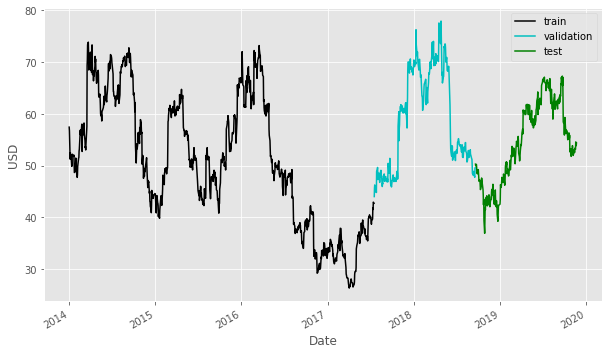

In [3]:
fig,ax=plt.subplots(figsize=(10,6))
for d,s in zip([train, val, test], ['k-', 'c-', 'g-']):
    ax = d.plot(x='date', y='adj_close', style=s, ax=ax)
ax.legend(['train', 'validation', 'test'])
ax.set_xlabel("Date")
ax.set_ylabel("USD")
plt.show();

### Modelling

In [4]:
def get_x_y(data, N, start):
    x, y = [], []
    for i in range(start, len(data)):
        x.append(data[i-N:i])
        y.append(data[i])
    x = np.array(x)
    y = np.array(y)
    
    return x, y

def train_pred_eval_model(x_train_scaled, \
                          y_train_scaled, \
                          x_test_scaled, \
                          y_test_scaled, \
                          scaler, \
                          lstm_units=50, \
                          dropout_prob=0.5, \
                          optimizer='adam', \
                          epochs=1, \
                          batch_size=1,
                          name='Algo'):
    
    # Create the LSTM network
    model = Sequential()
    model.add(LSTM(units=lstm_units, return_sequences=True, input_shape=(x_train_scaled.shape[1],1)))
    model.add(Dropout(dropout_prob)) # Add dropout with a probability of 0.5
    model.add(LSTM(units=lstm_units))
    model.add(Dropout(dropout_prob)) # Add dropout with a probability of 0.5
    model.add(Dense(1))

    # Compile and fit the LSTM network
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    model.fit(x_train_scaled, y_train_scaled, epochs=epochs, batch_size=batch_size, verbose=0)
    
    # Do prediction
    y_pred_scaled = model.predict(x_test_scaled)
    y_pred = scaler.inverse_transform(y_pred_scaled)
    
    # Get correct scale of y_cv
    y_test = scaler.inverse_transform(y_test_scaled)

    # Calculate RMSE and MAPE
    m = forecast_metrics(y_test, y_pred, name)
    
    return m, y_pred

### Dryrun

In [5]:
# initial parameters 

N = 5                          # for feature at day t, we use lags from t-1, t-2, ..., t-N as features. 
                               # initial value before tuning
lstm_units=64                  # lstm param. initial value before tuning.
dropout_prob=0.0               # lstm param. initial value before tuning.
optimizer='adam'               # lstm param. initial value before tuning.
epochs=20                      # lstm param. initial value before tuning.
batch_size=16                  # lstm param. initial value before tuning.

seed(42)
set_seed(42)

In [6]:
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(np.array(train['adj_close']).reshape(-1,1))

x_train, y_train = get_x_y(train_scaled, N, N)

train_val_scaled  = scaler.transform(np.array(train_val['adj_close']).reshape(-1,1))

# Split into x and y
x_val, y_val = get_x_y(train_val_scaled, N, ntrain)

scaler_final = MinMaxScaler(feature_range=(0, 1))
train_val_scaled_final = scaler_final.fit_transform(np.array(train_val['adj_close']).reshape(-1,1))

test_scaled  = scaler_final.transform(np.array(data['adj_close']).reshape(-1,1))

In [7]:
# Create the LSTM network
model = Sequential()
model.add(LSTM(units=lstm_units, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(Dropout(dropout_prob)) 
model.add(LSTM(units=lstm_units))
model.add(Dropout(dropout_prob)) 
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer=optimizer)
model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 5, 64)             16896     
_________________________________________________________________
dropout (Dropout)            (None, 5, 64)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 49,985
Trainable params: 49,985
Non-trainable params: 0
_________________________________________________________________


In [8]:
# Do prediction
y_pred = model.predict(x_val)
y_pred_inv = scaler.inverse_transform(y_pred)

# Get correct scale of y_cv
y_val_inv = scaler.inverse_transform(y_val)

m = forecast_metrics(y_val_inv, y_pred_inv, 'LSTM_Dryrun')

print(m)

                RMSE      MAPE     SMAPE    MinMax      Corr
LSTM_Dryrun  2.27058  2.555163  2.587684  2.520237  0.974637


In [13]:
rmse_bef_tuning = 2.27058
mape_pct_bef_tuning = 2.555163

# rmse_bef_tuning = m.RMSE[0]
# mape_pct_bef_tuning = m.MAPE[0]

#### Plotting on Valication set

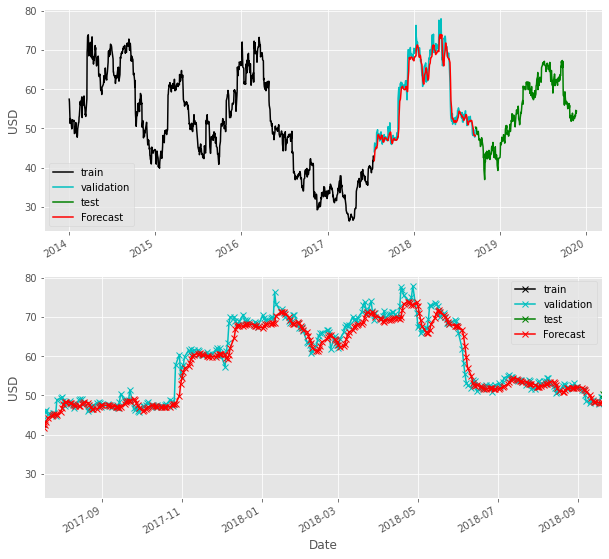

In [9]:
fig,ax=plt.subplots(2,1,figsize=(10,10))

for d,s in zip([train, val, test], ['k-', 'c-', 'g-']):
    ax[0] = d.plot(x='date', y='adj_close', style=s, ax=ax[0])
ax[0].plot(val.date, y_pred_inv, 'r-')
ax[0].legend(['train', 'validation', 'test', 'Forecast'])
ax[0].set_xlabel("")
ax[0].set_ylabel("USD")

for d,s in zip([train, val, test], ['kx-', 'cx-', 'gx-']):
    ax[1] = d.plot(x='date', y='adj_close', style=s, ax=ax[1])
ax[1].plot(val.date, y_pred_inv, 'rx-')
ax[1].legend(['train', 'validation', 'test', 'Forecast'])
ax[1].set_xlim([val.date.min(), val.date.max()])
ax[1].set_xlabel("Date")
ax[1].set_ylabel("USD")
#ax[1].text(0.5, 0.5, "Zoomed In")

plt.show();

### Build Model

### Tuning N (no. of days to use as features)

In [11]:
metrics = pd.DataFrame()

for N in range(1,31):

    x_train_scaled, y_train_scaled = get_x_y(train_scaled, N, N)
    x_val_scaled, y_val_scaled = get_x_y(train_val_scaled, N, ntrain)
    
    # Train, predict and eval model
    m, _ = train_pred_eval_model( x_train_scaled, \
                                  y_train_scaled, \
                                  x_val_scaled, \
                                  y_val_scaled, \
                                  scaler, \
                                  lstm_units=lstm_units, \
                                  dropout_prob=dropout_prob, \
                                  optimizer='adam', \
                                  epochs=epochs, \
                                  batch_size=batch_size,
                                  name=N)
    metrics = metrics.append(m)
    print(N, end = '...')
    
print()
print(metrics.MAPE.idxmin(), metrics.MAPE.min()) 

print(metrics)
N_opt = metrics.MAPE.idxmin()

1...2...3...4...5...6...7...8...9...10...11...12...13...14...15...16...17...18...19...20...21...22...23...24...25...26...27...28...29...30...
20 1.9145987815265966
        RMSE      MAPE     SMAPE    MinMax      Corr
1   1.680061  1.959013  1.976406  1.937908  0.985950
2   1.950068  2.184763  2.192323  2.142158  0.979118
3   2.426868  2.796538  2.850264  2.774345  0.975345
4   2.192968  2.455104  2.462506  2.399464  0.973574
5   2.251793  2.531187  2.563646  2.497582  0.975273
6   2.182212  2.441568  2.470503  2.409183  0.976984
7   2.142135  2.548908  2.532044  2.471591  0.977416
8   1.986773  2.393208  2.382907  2.329773  0.979298
9   2.226800  2.500213  2.539938  2.476316  0.977300
10  1.966441  2.184384  2.203680  2.152593  0.979551
11  1.968089  2.281059  2.282897  2.231494  0.978737
12  1.911406  2.180742  2.176805  2.128552  0.981397
13  1.816246  2.092609  2.090079  2.046181  0.982425
14  1.817993  2.041784  2.048851  2.004602  0.981848
15  2.389148  2.848624  2.909997  2.83783

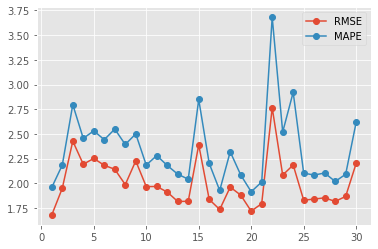

In [12]:
metrics[['RMSE', 'MAPE']].plot(style='o-');

In [14]:
metrics.sort_values(by='MAPE').head(5)

,RMSE,MAPE,SMAPE,MinMax,Corr
20,1.718167,1.914599,1.921904,1.882349,0.983841
17,1.735213,1.927582,1.935057,1.894609,0.983527
1,1.680061,1.959013,1.976406,1.937908,0.985950
21,1.794587,2.013466,2.021151,1.978341,0.982359
28,1.816476,2.018715,2.041015,1.997053,0.983341


In [16]:
### Tuning model - epochs and batch_size

param_label = 'epochs'
param_list = [1, 10, 20, 30, 50, 100]

param2_label = 'batch_size'
param2_list = [8, 16, 32, 64, 128]

x_train_scaled, y_train_scaled = get_x_y(train_scaled, N_opt, N_opt)
x_val_scaled, y_val_scaled = get_x_y(train_val_scaled, N_opt, ntrain)

metrics = pd.DataFrame()

for param in param_list:
    for param2 in param2_list:
        # Train, predict and eval model
        m, _ = train_pred_eval_model(x_train_scaled, \
                                              y_train_scaled, \
                                              x_val_scaled, \
                                              y_val_scaled, \
                                              scaler, \
                                              lstm_units=lstm_units, \
                                              dropout_prob=dropout_prob, \
                                              optimizer='adam', \
                                              epochs=param, \
                                              batch_size=param2,
                                              name=(param, param2)
                                             )
        # collect metrics
        metrics = metrics.append(m)
        print("|", end='...')
        
print()
print(metrics.MAPE.idxmin(), metrics.MAPE.min()) 
print(metrics)

epochs_opt, batch_size_opt = metrics.MAPE.idxmin()

|...|...|...|...|...|...|...|...|...|...|...|...|...|...|...|...|...|...|...|...|...|...|...|...|...|...|...|...|...|...
(100, 32) 1.7857976773462965
                RMSE      MAPE     SMAPE    MinMax      Corr
(1, 8)      3.442675  3.980421  3.975195  3.816788  0.934636
(1, 16)     3.660020  4.333567  4.373808  4.198670  0.929232
(1, 32)     3.944925  5.193137  5.199549  4.998370  0.923154
(1, 64)     5.306904  6.419612  6.705805  6.368117  0.924616
(1, 128)    4.864561  5.863156  6.073231  5.785370  0.918598
(10, 8)     1.972801  2.304863  2.300492  2.248761  0.979140
(10, 16)    2.907614  3.508869  3.590546  3.480330  0.966960
(10, 32)    2.825856  3.265255  3.277419  3.172406  0.956171
(10, 64)    3.202806  3.672256  3.652094  3.516503  0.943918
(10, 128)   3.544685  4.133561  4.149079  3.980955  0.931368
(20, 8)     2.482580  3.304505  3.379731  3.298182  0.985032
(20, 16)    1.800144  1.993321  2.007884  1.964783  0.982599
(20, 32)    2.423079  2.741712  2.776942  2.700571  0.970

In [21]:
#metrics[[param_label, param2_label]] = pd.DataFrame(metrics.index.to_list()).values
def plot_two_params(metrics, param_label, param2_label):
    temp= pd.DataFrame(metrics.index.to_list()).values
    metrics[param_label] = temp[:,0]
    metrics[param2_label] = temp[:,1]

    color_list = [
        '#1f77b4',  # muted blue
        '#ff7f0e',  # safety orange
        '#2ca02c',  # cooked asparagus green
        '#d62728',  # brick red
        '#9467bd',  # muted purple
        '#8c564b',  # chestnut brown
        '#e377c2',  # raspberry yogurt pink
        '#7f7f7f',  # middle gray
        '#bcbd22',  # curry yellow-green
        '#17becf'   # blue-teal
    ]

    legend_list = []

    fig,ax=plt.subplots(1,1,figsize=(10,6))
    for i in range(len(param2_list)):
        temp = metrics[metrics[param2_label]==param2_list[i]]
        ax = temp.plot(x=param_label, y='MAPE', color=color_list[i%len(color_list)], marker='s', ax=ax)
        legend_list.append(f"{param2_label}_{param2_list[i]}")

    ax.set_xlabel(param_label)
    ax.set_ylabel("MAPE")
    plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure
    plt.show();
    
#plot_two_params(metrics, param_label, param2_label)

In [19]:
### Tuning model - LSTM units and dropout prob

param_label = 'lstm_units'
param_list = [32, 50, 64, 128]

param2_label = 'dropout_prob'
param2_list = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

x_train_scaled, y_train_scaled = get_x_y(train_scaled, N_opt, N_opt)
x_val_scaled, y_val_scaled = get_x_y(train_val_scaled, N_opt, ntrain)

metrics = pd.DataFrame()

for param in param_list:
    for param2 in param2_list:
        # Train, predict and eval model
        m, _ = train_pred_eval_model(x_train_scaled, \
                                              y_train_scaled, \
                                              x_val_scaled, \
                                              y_val_scaled, \
                                              scaler, \
                                              lstm_units=param, \
                                              dropout_prob=param2, \
                                              optimizer='adam', \
                                              epochs=epochs_opt, \
                                              batch_size=batch_size_opt,
                                              name=(param, param2)
                                             )
        # collect metrics
        metrics = metrics.append(m)
        print("|", end='...')
        
print()
print(metrics.MAPE.idxmin(), metrics.MAPE.min()) 
print(metrics)

lsmt_units_opt, dropout_prob_opt = metrics.MAPE.idxmin()

|...|...|...|...|...|...|...|...|...|...|...|...|...|...|...|...|...|...|...|...|...|...|...|...|...|...|...|...|...|...|...|...|...|...|...|...
(64, 0.0) 1.7922624351505978
                RMSE      MAPE     SMAPE    MinMax      Corr
(32, 0.0)   1.622188  1.822502  1.822957  1.787345  0.985583
(32, 0.1)   1.762109  2.006261  2.006075  1.964094  0.983064
(32, 0.2)   1.843469  2.055620  2.062437  2.016822  0.981358
(32, 0.3)   1.892008  2.150408  2.154147  2.106219  0.980327
(32, 0.4)   2.009334  2.286885  2.292959  2.239324  0.978089
(32, 0.5)   2.124512  2.450470  2.461543  2.402596  0.976450
(32, 0.6)   2.207016  2.624597  2.622361  2.557207  0.974489
(32, 0.7)   2.524409  2.967302  3.005838  2.927255  0.974183
(32, 0.8)   3.040281  3.600058  3.665405  3.553830  0.966307
(50, 0.0)   1.622906  1.813949  1.817732  1.782483  0.985574
(50, 0.1)   1.750903  1.980336  1.999567  1.958991  0.984768
(50, 0.2)   2.212718  2.699125  2.750963  2.688487  0.983748
(50, 0.3)   1.892382  2.151414  2

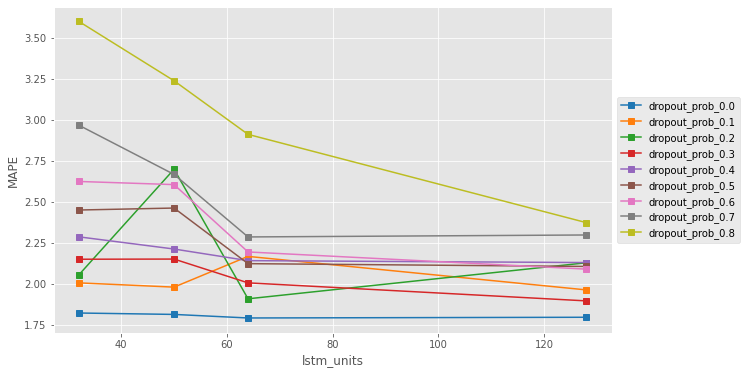

In [22]:
plot_two_params(metrics, param_label, param2_label)

In [25]:
param_label = 'learning_rate'
param_list = [3e-4, 1e-3, 1e-2, 1e-1]

param2_label = 'epochs2'  # epochs_opt = 100
param2_list = [100, 200, 300, 400, 500]

x_train_scaled, y_train_scaled = get_x_y(train_scaled, N_opt, N_opt)
x_val_scaled, y_val_scaled = get_x_y(train_val_scaled, N_opt, ntrain)

metrics = pd.DataFrame()

for param in param_list:
    for param2 in param2_list:
        
        # Train, predict and eval model
        m, _ = train_pred_eval_model(x_train_scaled, \
                                              y_train_scaled, \
                                              x_val_scaled, \
                                              y_val_scaled, \
                                              scaler, \
                                              lstm_units=lsmt_units_opt, \
                                              dropout_prob=dropout_prob_opt, \
                                              optimizer=keras.optimizers.Adam(lr=param, beta_1=0.9, beta_2=0.999), \
                                              epochs=param2, \
                                              batch_size=batch_size_opt,
                                              name=(param, param2)
                                             )
        # collect metrics
        metrics = metrics.append(m)
        print("|", end='...')
        
print()
print(metrics.MAPE.idxmin(), metrics.MAPE.min()) 
print(metrics)

learning_rate_opt, epochs2_opt = metrics.MAPE.idxmin()

|...|...|...|...|...|...|...|...|...|...|...|...|...|...|...|...|...|...|...|...
(0.0003, 500) 1.7864402628427967
                    RMSE       MAPE      SMAPE     MinMax      Corr
(0.0003, 100)   1.747027   2.027642   2.022645   1.981226  0.983723
(0.0003, 200)   1.624532   1.818299   1.827797   1.792444  0.985823
(0.0003, 300)   1.663885   1.958968   1.947111   1.909575  0.985985
(0.0003, 400)   1.737343   1.996556   2.019092   1.979134  0.985997
(0.0003, 500)   1.603145   1.786440   1.790004   1.755359  0.985942
(0.001, 100)    1.605863   1.789381   1.792263   1.757547  0.985866
(0.001, 200)    1.629162   1.838559   1.851354   1.815183  0.986069
(0.001, 300)    1.740338   2.124357   2.104758   2.063645  0.985982
(0.001, 400)    1.775956   2.058788   2.084123   2.042567  0.986057
(0.001, 500)    1.613243   1.797803   1.801295   1.766285  0.985786
(0.01, 100)     1.960738   2.542776   2.506449   2.454918  0.986022
(0.01, 200)     1.643134   1.825856   1.833743   1.797343  0.985495
(0

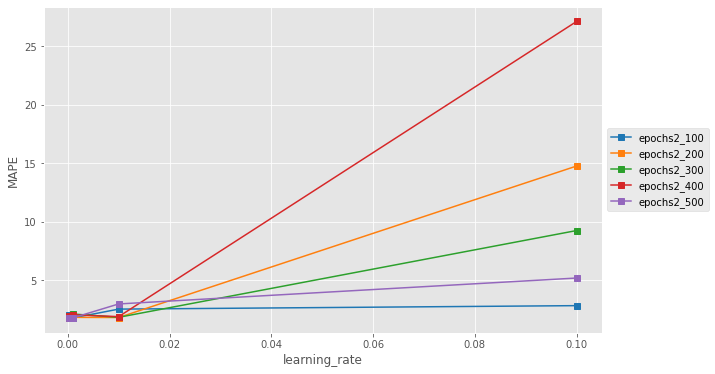

In [31]:
plot_two_params(metrics, param_label, param2_label)

In [26]:
# select
learning_rate_opt, epochs_opt = 0.001, 100

### Final model, test set

In [32]:
x_train_val_scaled, y_train_val_scaled = get_x_y(train_val_scaled_final, N_opt, N_opt)
x_test_scaled, y_test_scaled = get_x_y(test_scaled, N_opt, ntrval)

       
# Train, predict and eval model
metrics, y_pred = train_pred_eval_model(x_train_val_scaled, \
                                      y_train_val_scaled, \
                                      x_test_scaled, \
                                      y_test_scaled, \
                                      scaler, \
                                      lstm_units=lsmt_units_opt, \
                                      dropout_prob=dropout_prob_opt, \
                                      optimizer=keras.optimizers.Adam(lr=learning_rate_opt, beta_1=0.9, beta_2=0.999), \
                                      epochs=epochs_opt, \
                                      batch_size=batch_size_opt,
                                      name='lstm'
                                     )

print(metrics)
test[f'forcast'] = y_pred

         RMSE      MAPE    SMAPE    MinMax      Corr
lstm  1.32884  2.039273  2.05818  2.025391  0.986681


### Plotting on test set

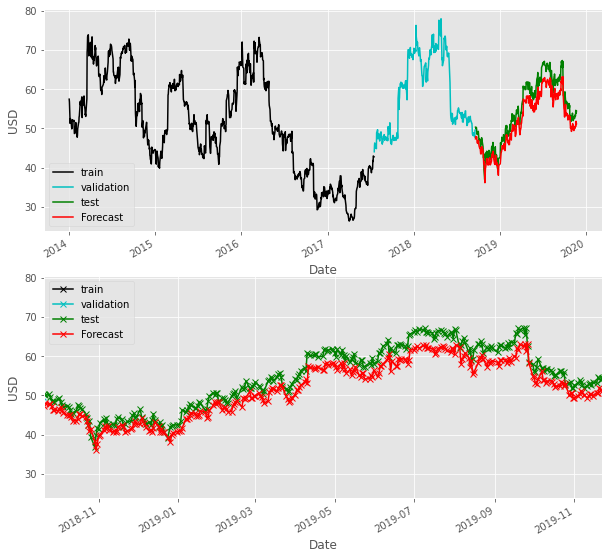

In [33]:
fig,ax=plt.subplots(2,1,figsize=(10,10))

for d,s in zip([train, val, test], ['k-', 'c-', 'g-']):
    ax[0] = d.plot(x='date', y='adj_close', style=s, ax=ax[0])
ax[0].plot(test.date, y_pred, 'r-')
ax[0].legend(['train', 'validation', 'test', 'Forecast'])
ax[0].set_xlabel("Date")
ax[0].set_ylabel("USD")

for d,s in zip([train, val, test], ['kx-', 'cx-', 'gx-']):
    ax[1] = d.plot(x='date', y='adj_close', style=s, ax=ax[1])
ax[1].plot(test.date, y_pred, 'rx-')
ax[1].legend(['train', 'validation', 'test', 'Forecast'])
ax[1].set_xlim([test.date.min(), test.date.max()])
ax[1].set_xlabel("Date")
ax[1].set_ylabel("USD")
#ax[1].text(0.5, 0.5, "Zoomed In")

plt.show();

### Save predictions

In [34]:
test.to_csv("./out/test_lstm.csv")

In [36]:
print(metrics)

         RMSE      MAPE    SMAPE    MinMax      Corr
lstm  1.32884  2.039273  2.05818  2.025391  0.986681
